# Emogotchi ML Pipeline: Emotion Prediction & Action Engine

## Overview

This notebook contains the complete machine learning pipeline for the CS3237 Emogotchi project. The primary goal is to develop and evaluate models capable of predicting a user's emotional state (e.g., "sad," "plain," "happy") based on physiological and environmental sensor data.

### Notebook Workflow

This notebook is broken down into three main stages:

1.  **Data Loading and Preprocessing:** We load the dataset, scale the numerical features for our models, and encode the text-based emotion labels into a machine-readable format.
2.  **Model Training and Evaluation:** We build, train, and test two distinct machine learning models to compare their performance on this task:
    * **Model 1: Random Forest (Baseline):** A classic ML model that predicts emotion based on a single "snapshot" of sensor data.
    * **Model 2: LSTM Network (Advanced):** A recurrent neural network that analyzes *sequences* of data over time to capture trends (e.g., "HRV *dropping* over 10 seconds"), which is more representative of a real stress response.
3.  **Actionable Rules Engine:** We define a simple logic-based function that takes the model's final prediction (e.g., "sad") and the current sensor readings (e.g., "temp is 31°C") to decide on a concrete action (e.g., `switch on AC`).

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Import Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# To save the trained model
import joblib

In [11]:
import pandas as pd
import numpy as np

# Define the number of samples per class
n_samples_per_class = 500
total_samples = n_samples_per_class * 3

# --- Create realistic timestamps ---
base_time = pd.Timestamp.now()
timestamps = pd.date_range(end=base_time, periods=total_samples, freq='16S')

# --- Define Sensor Profiles for Each Emotion ---

# Profile 1: "happy" (Relaxed, Comfortable)
happy_data = pd.DataFrame({
    'bpm': np.random.normal(loc=75, scale=5, size=n_samples_per_class), 
    'temperature': np.random.normal(loc=26.5, scale=0.5, size=n_samples_per_class),
    'humidity': np.random.normal(loc=55, scale=3, size=n_samples_per_class),
    'noise': np.random.normal(loc=45, scale=5, size=n_samples_per_class),
    'ldr': np.random.normal(loc=500, scale=50, size=n_samples_per_class),
    'in_motion': np.random.normal(loc=0.1, scale=0.05, size=n_samples_per_class),
    'emotion': 'happy'
})

# Profile 2: "plain" (Neutral / Focused)
plain_data = pd.DataFrame({
    'bpm': np.random.normal(loc=85, scale=5, size=n_samples_per_class),
    'temperature': np.random.normal(loc=28.0, scale=0.5, size=n_samples_per_class),
    'humidity': np.random.normal(loc=60, scale=3, size=n_samples_per_class),
    'noise': np.random.normal(loc=38, scale=3, size=n_samples_per_class),
    'ldr': np.random.normal(loc=400, scale=40, size=n_samples_per_class),
    'in_motion': np.random.normal(loc=0.05, scale=0.02, size=n_samples_per_class),
    'emotion': 'plain'
})

# Profile 3: "stressed" (Stressed / Fatigued)
sad_data = pd.DataFrame({
    'bpm': np.random.normal(loc=110, scale=10, size=n_samples_per_class), 
    'temperature': np.random.normal(loc=31.0, scale=1.0, size=n_samples_per_class),
    'humidity': np.random.normal(loc=65, scale=3, size=n_samples_per_class),
    'noise': np.random.normal(loc=70, scale=8, size=n_samples_per_class),
    'ldr': np.random.normal(loc=200, scale=50, size=n_samples_per_class),
    'in_motion': np.random.normal(loc=0.7, scale=0.2, size=n_samples_per_class),
    'emotion': 'stressed'
})

# --- Combine, Shuffle, and Clean the Data ---
df = pd.concat([happy_data, plain_data, sad_data], ignore_index=True)
df_shuffled = df.sample(frac=1).reset_index(drop=True)

# Add timestamps
df_shuffled['timestamp'] = timestamps

# --- Use .clip() to enforce hard boundaries ---
df_shuffled['bpm'] = df_shuffled['bpm'].clip(lower=50, upper=140)
df_shuffled['noise'] = df_shuffled['noise'].clip(lower=30, upper=90)
df_shuffled['in_motion'] = df_shuffled['in_motion'].clip(lower=0)
df_shuffled['ldr'] = df_shuffled['ldr'].clip(lower=50, upper=1000)
df_shuffled['temperature'] = df_shuffled['temperature'].clip(lower=24, upper=34)
df_shuffled['humidity'] = df_shuffled['humidity'].clip(lower=50, upper=70)

# --- Round to correct decimal places and types ---
df_shuffled['bpm'] = df_shuffled['bpm'].round(0).astype(int)
df_shuffled['temperature'] = df_shuffled['temperature'].round(1)
df_shuffled['humidity'] = df_shuffled['humidity'].round(1)
df_shuffled['noise'] = df_shuffled['noise'].round(0).astype(int)
df_shuffled['ldr'] = df_shuffled['ldr'].round(0).astype(int)
df_shuffled['in_motion'] = df_shuffled['in_motion'].round(0).astype(int)

# --- Format timestamp to time-only string ---
df_shuffled['timestamp'] = df_shuffled['timestamp'].dt.strftime('%H:%M:%S')

# Reorder columns to match your request
final_columns = ['timestamp', 'bpm', 'temperature', 'humidity', 'noise', 'ldr', 'in_motion', 'emotion']
df_final = df_shuffled[final_columns]

# Save to a CSV file for training
df_final.to_csv('labeled_sensor_data_for_training_v3.csv', index=False)

print("Simulated, labeled dataset (v3) created as 'labeled_sensor_data_for_training_v3.csv'")
print("\n--- New Dataset Head ---")
print(df_final.head())

Simulated, labeled dataset (v3) created as 'labeled_sensor_data_for_training_v3.csv'

--- New Dataset Head ---
  timestamp  bpm  temperature  humidity  noise  ldr  in_motion   emotion
0  10:27:04   88         27.6      58.8     33  369          0     plain
1  10:27:20  110         32.4      68.4     74  161          1  stressed
2  10:27:36   88         26.5      58.0     39  398          0     plain
3  10:27:52   91         27.2      66.4     41  381          0     plain
4  10:28:08   87         28.4      60.4     44  453          0     plain


C:\Users\dongh\AppData\Local\Temp\ipykernel_17076\2258062349.py:10: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  timestamps = pd.date_range(end=base_time, periods=total_samples, freq='16S')


In [12]:
# Load the labeled dataset for training
try:
    data = pd.read_csv("labeled_sensor_data_for_training_v3.csv")
except FileNotFoundError:
    print("Please run the data generation cell (Step 2) first.")
    
print(f"Dataset shape: {data.shape}")
print("\n--- Data Info ---")
data.info()
print("\nSample of training data:")
print(data.head())

Dataset shape: (1500, 8)

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   timestamp    1500 non-null   object 
 1   bpm          1500 non-null   int64  
 2   temperature  1500 non-null   float64
 3   humidity     1500 non-null   float64
 4   noise        1500 non-null   int64  
 5   ldr          1500 non-null   int64  
 6   in_motion    1500 non-null   int64  
 7   emotion      1500 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 93.9+ KB

Sample of training data:
  timestamp  bpm  temperature  humidity  noise  ldr  in_motion   emotion
0  10:27:04   88         27.6      58.8     33  369          0     plain
1  10:27:20  110         32.4      68.4     74  161          1  stressed
2  10:27:36   88         26.5      58.0     39  398          0     plain
3  10:27:52   91         27.2      66.4     41  3

In [13]:
# Define our features (inputs) and target (output)
# We drop 'timestamp' as it's not a predictive feature
features = ['bpm', 'temperature', 'humidity', 'noise', 'ldr', 'in_motion']
target = 'emotion'

# Separate features and target
X = data[features]
y = data[target]

# Define a preprocessor
numerical_features = features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features)
    ],
    remainder='passthrough'
)

In [14]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (1200, 6)
Testing data shape: (300, 6)


In [15]:
# Define the models we want to compare
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Support Vector Machine (SVM)": SVC(kernel='rbf', probability=True, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

# Create a pipeline for each model
pipelines = {}
for name, model in models.items():
    pipelines[name] = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
print(f"Defined {len(pipelines)} models to test.")

Defined 4 models to test.


In [16]:
results = []
best_model = None
best_accuracy = 0.0

print("--- Starting Model Training and Evaluation ---")

for name, pipeline in pipelines.items():
    print(f"Training {name}...")
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Test the model
    y_pred = pipeline.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Store results
    results.append({
        "Model": name,
        "Accuracy": accuracy
    })
    
    print(f"  Accuracy: {accuracy:.4f}")
    
    # Save the best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = pipeline
        
print("--- Evaluation Complete ---")
print(f"Best model: {best_model.named_steps['model'].__class__.__name__} with accuracy {best_accuracy:.4f}")

# Save the best performing model to a file
joblib.dump(best_model, 'best_emogotchi_model.pkl')
print("Best model saved to 'best_emogotchi_model.pkl'")

--- Starting Model Training and Evaluation ---
Training Logistic Regression...
  Accuracy: 0.9933
Training Random Forest...
  Accuracy: 0.9867
Training Support Vector Machine (SVM)...
  Accuracy: 0.9933
Training Gradient Boosting...
  Accuracy: 0.9867
--- Evaluation Complete ---
Best model: LogisticRegression with accuracy 0.9933
Best model saved to 'best_emogotchi_model.pkl'


In [17]:
# Create a DataFrame from the results
results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False).reset_index(drop=True)

print("--- Model Performance Comparison ---")
print(results_df)

--- Model Performance Comparison ---
                          Model  Accuracy
0           Logistic Regression  0.993333
1  Support Vector Machine (SVM)  0.993333
2                 Random Forest  0.986667
3             Gradient Boosting  0.986667


Accuracy comparison plot saved as 'model_accuracy_comparison.png'


C:\Users\dongh\AppData\Local\Temp\ipykernel_17076\206823175.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Accuracy", y="Model", data=results_df, palette="viridis")


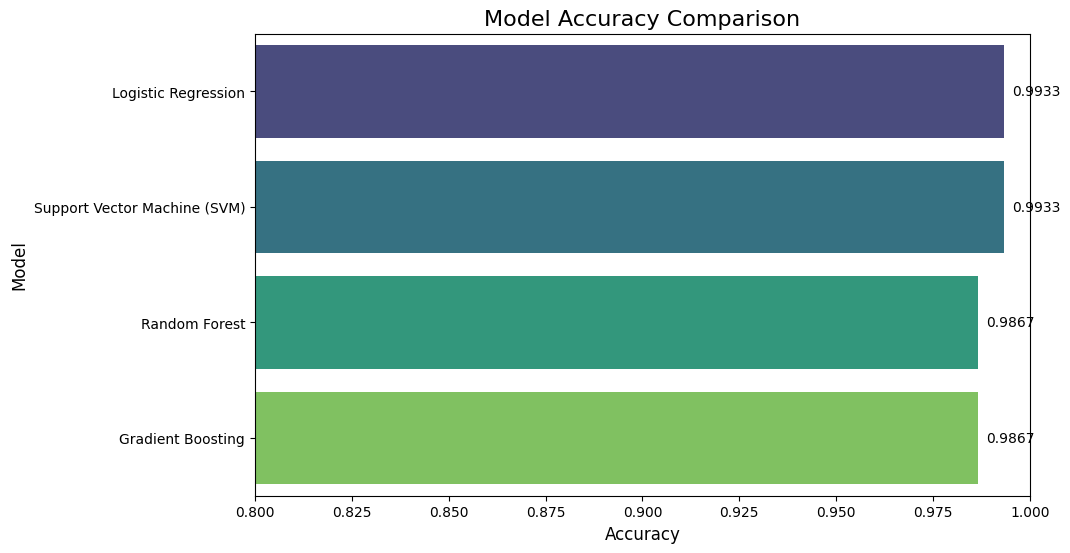

In [18]:
plt.figure(figsize=(10, 6))
sns.barplot(x="Accuracy", y="Model", data=results_df, palette="viridis")
plt.title("Model Accuracy Comparison", fontsize=16)
plt.xlabel("Accuracy", fontsize=12)
plt.ylabel("Model", fontsize=12)
plt.xlim(0.8, 1.0)
# Add accuracy labels to the bars
for index, row in results_df.iterrows():
    plt.text(row.Accuracy + 0.002, index, f"{row.Accuracy:.4f}", va='center')
    
plt.savefig("model_accuracy_comparison.png")
print("Accuracy comparison plot saved as 'model_accuracy_comparison.png'")
plt.show()

Confusion matrix plot saved as 'best_model_confusion_matrix.png'


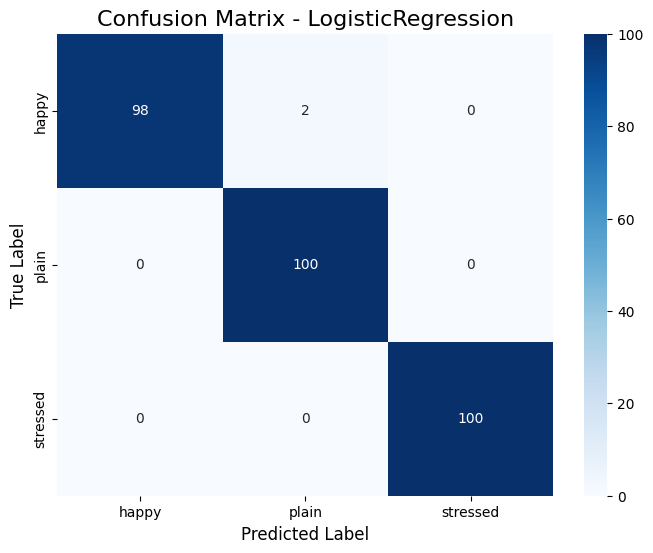

In [19]:
# Get predictions from the best model
y_pred_best = best_model.predict(X_test)

# Get class labels
labels = sorted(y_test.unique())

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_best, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix - {best_model.named_steps['model'].__class__.__name__}", fontsize=16)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.savefig("best_model_confusion_matrix.png")
print("Confusion matrix plot saved as 'best_model_confusion_matrix.png'")
plt.show()

In [20]:
# This only works for tree-based models like Random Forest or Gradient Boosting
try:
    model_step = best_model.named_steps['model']
    
    if hasattr(model_step, 'feature_importances_'):
        importances = model_step.feature_importances_
        
        feature_importance_df = pd.DataFrame({
            'Feature': features,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='rocket')
        plt.title('Feature Importance for Best Model', fontsize=16)
        plt.savefig("feature_importance.png")
        print("Feature importance plot saved as 'feature_importance.png'")
        plt.show()
    else:
        print(f"The best model ({type(model_step).__name__}) does not provide feature importances.")
except Exception as e:
    print(f"Could not get feature importances: {e}")

The best model (LogisticRegression) does not provide feature importances.


In [21]:
# Load the best model we saved earlier
try:
    loaded_model = joblib.load('best_emogotchi_model.pkl')
    print("Best model 'best_emogotchi_model.pkl' loaded for Rules Engine.")
except FileNotFoundError:
    print("Model file not found. Using model from memory.")
    loaded_model = best_model 

def get_emogotchi_action(sensor_reading):
    """
    Takes a dictionary of new sensor data and returns the predicted emotion
    and a list of actions.
    
    sensor_reading: A dict, e.g.,
    {
        'bpm': 115.0, 
        'temperature': 31.0, 
        'humidity': 65.0, 
        'noise': 70.0, 
        'ldr': 200.0,
        'in_motion': 0.7
    }
    """
    emotion = "unknown"
    actions = []
    
    # --- 1. Check Hard Thresholds First ---
    if sensor_reading['bpm'] > 130:
        emotion = "stressed"
    elif sensor_reading['bpm'] < 50:
        emotion = "stressed"
    elif sensor_reading['noise'] > 85:
        emotion = "stressed"
    elif sensor_reading['temperature'] > 32:
        emotion = "stressed"
    
    # --- 2. If no hard rule, use ML Model ---
    if emotion == "unknown":
        # Convert the dictionary to a DataFrame for the pipeline
        data_df = pd.DataFrame([sensor_reading])
        # Reorder columns to match the training features
        data_df = data_df[features] 
        
        # Predict the emotion
        emotion = loaded_model.predict(data_df)[0]
        
    # --- 3. Determine Actions Based on Emotion AND Sensor Data ---
    if emotion == "stressed":
        if sensor_reading['temperature'] > 28:
            actions.append("turn on AC")
        if sensor_reading['ldr'] < 250:
            actions.append("turn on light")
        if sensor_reading['humidity'] > 62:
            actions.append("open window")
            
    elif emotion == "happy":
        if sensor_reading['temperature'] < 25:
            actions.append("turn off AC")
            
    elif emotion == "plain":
        actions.append("Keep up the focus!")

    # If no specific action is triggered
    if not actions:
        actions.append("no action")
        
    return emotion, actions

Best model 'best_emogotchi_model.pkl' loaded for Rules Engine.


In [22]:
# --- Example 1: Stressed by environment (ML Prediction) ---
sample_data_1 = {
    'bpm': 115.0,
    'temperature': 31.0,
    'humidity': 68.0,
    'noise': 70.0,
    'ldr': 200.0,
    'in_motion': 0.7
}

predicted_emotion_1, recommended_actions_1 = get_emogotchi_action(sample_data_1)
print(f"Data 1 (Stressed by Env):")
print(f"  Predicted Emotion: {predicted_emotion_1}")
print(f"  Recommended Actions: {recommended_actions_1}\n")


# --- Example 2: Stressed by high BPM (Hard Threshold) ---
sample_data_2 = {
    'bpm': 135.0,
    'temperature': 25.0,
    'humidity': 55.0,
    'noise': 40.0,
    'ldr': 500.0,
    'in_motion': 0.1
}

predicted_emotion_2, recommended_actions_2 = get_emogotchi_action(sample_data_2)
print(f"Data 2 (High BPM):")
print(f"  Predicted Emotion: {predicted_emotion_2}")
print(f"  Recommended Actions: {recommended_actions_2}\n")


# --- Example 3: Happy/Relaxed (ML Prediction) ---
sample_data_3 = {
    'bpm': 72.0,
    'temperature': 25.0,
    'humidity': 55.0,
    'noise': 40.0,
    'ldr': 500.0,
    'in_motion': 0.1
}

predicted_emotion_3, recommended_actions_3 = get_emogotchi_action(sample_data_3)
print(f"Data 3 (Happy/Relaxed):")
print(f"  Predicted Emotion: {predicted_emotion_3}")
print(f"  Recommended Actions: {recommended_actions_3}\n")

Data 1 (Stressed by Env):
  Predicted Emotion: stressed
  Recommended Actions: ['turn on AC', 'turn on light', 'open window']

Data 2 (High BPM):
  Predicted Emotion: stressed
  Recommended Actions: ['no action']

Data 3 (Happy/Relaxed):
  Predicted Emotion: happy
  Recommended Actions: ['no action']

